In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ca78c4a8-5eac-e20d-f989-46f09e97be27)


In [1]:
# import thư viện
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [22]:
# load dữ liệu
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [23]:
# Chia dữ liệu theo tỷ lệ train/val : 0.8/0.2

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(x_train, y_train):
    X_train_data, X_val_data = x_train[train_index], x_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


In [24]:
# Reshape lại dữ liệu cho đúng kích thước input

X_train = X_train_data.reshape(X_train_data.shape[0], 32, 32, 3)
X_val = X_val_data.reshape(X_val_data.shape[0], 32, 32, 3)
X_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

# Normalize pixel về giá trị [0-1]

X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.

In [25]:
# One-hot encoding label

y_train = to_categorical(y_train_data, 100)
y_val = to_categorical(y_val_data, 100)
y_test = to_categorical(y_test, 100)
print('Dữ liệu y ban đầu ', y_train_data[0])
print('Dữ liệu y sau one-hot encoding ',y_train[0])

Dữ liệu y ban đầu  [71]
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [26]:
# Cut-out augmentation 

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

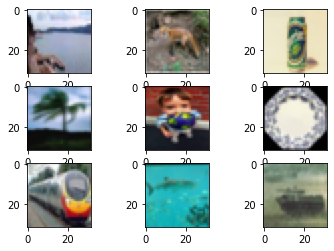

In [27]:
# Visualize ảnh gốc
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i])
# show the figure
plt.show()

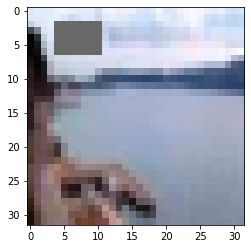

In [38]:
# Visualize image with cut-out pixel = False
cutout = get_random_eraser(v_l=0, v_h=1, pixel_level=False)
X_ = cutout(X_train[0])
plt.imshow(X_)

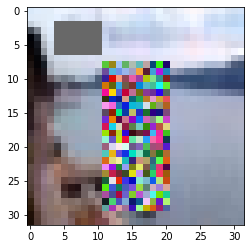

In [40]:
# Visualize image with cut-out pixel = True
cutout = get_random_eraser(v_l=0, v_h=1, pixel_level=True)
X_ = cutout(X_train[0])
plt.imshow(X_)

In [ ]:
# Augmentation data
datagen = ImageDataGenerator(
          rotation_range=40,  # phạm vi random góc xoay image 
          width_shift_range=0.2, 
          height_shift_range=0.2,
          shear_range = 0.2,
          zoom_range = 0.2,
          horizontal_flip=True,
          fill_mode='nearest',
          preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))

In [ ]:
# load pretrained model từ tf-hub

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '-1k':
    ckpt_type = ''
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  
  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 224)
  return hub_url, image_size

TF version: 2.5.0
Hub version: 0.12.0
Phsical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow_hub as hub
model_name = 'efficientnetv2-s' # sử dụng pretrained model EfficientnetV2-S 
ckpt_type = '-1k'   # Model đã train trên tập ImageNet-1k
hub_type = 'feature-vector' # Sử dụng ['feature-vector'] để fine-tuning
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)

In [ ]:
# Fine-tuning model

do_fine_tuning = True # Fine-tune cả model
num_classes = 100

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[32, 32, 3]),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.UpSampling2D(),
    hub.KerasLayer(hub_url, trainable=do_fine_tuning),
    # tf.keras.layers.Dense(640),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes,activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              20331360  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
Total params: 20,459,460
Trainable params: 20,305,588
Non-trainable params: 153,872
______________________________________

In [25]:
# Early Stopping để ngăn overfitting 
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 9, restore_best_weights=True)

# Reduce learning rate nếu qua một số epoch không cải thiện val_acc 
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience = 3, factor= 0.5, min_lr= 1e-6, verbose=1)

# Checkpoint save best model
filepath = '/content/drive/MyDrive/effnetv2s-sgd-cutout.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Model compiling
model.compile(
  optimizer= tf.keras.optimizers.SGD(learning_rate=0.005, momentum= 0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
data_augmentation = True 

# Train với data không augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(X_val, y_val),
              shuffle=True,
              callbacks=[rlrop,checkpoint])
else:
    print('Using real-time data augmentation.')

    # Train với data augmentation + cut-out
    H_1 = model.fit(datagen.flow(X_train, y_train, batch_size = 16),
              steps_per_epoch=X_train.shape[0] // 16,
              validation_data=(X_val, y_val),
              epochs = 20, verbose=1, workers=4,
              callbacks=[rlrop,checkpoint,early_stop])


Using real-time data augmentation.
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2500/2500 [==============================] - 853s 322ms/step - loss: 2.7189 - accuracy: 0.4397 - val_loss: 1.5180 - val_accuracy: 0.7771

Epoch 00001: val_accuracy improved from -inf to 0.77710, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 2/20
2500/2500 [==============================] - 770s 308ms/step - loss: 1.8240 - accuracy: 0.6797 - val_loss: 1.3887 - val_accuracy: 0.8125

Epoch 00002: val_accuracy improved from 0.77710 to 0.81250, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 3/20
2500/2500 [==============================] - 772s 309ms/step - loss: 1.6465 - accuracy: 0.7336 - val_loss: 1.3514 - val_accuracy: 0.8257

Epoch 00003: val_accuracy improved from 0.81250 to 0.82570, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 4/20
2500/2500 [==============================] - 771s 308ms/step - loss: 1.5362 - accuracy: 0.7661 - val_loss: 1.3409 - val_accuracy: 0.8335

Epoch 00004: val_accuracy improved from 0.82570 t

In [ ]:
# Save lại history của train_1
np.save('/content/drive/MyDrive/effnetv2s-sgd-cutout-1.npy',H_1.history)

In [ ]:
# Load model đã save để train tiếp 20 epoch
loaded_model = keras.models.load_model('/content/drive/MyDrive/effnetv2s-sgd-cutout.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Do Colab giới hạn về thời gian sử dụng GPU nên em save model để train với 20 epoch tiếp theo 

H_2 = loaded_model.fit(datagen.flow(X_train, y_train, batch_size = 16),
              steps_per_epoch=X_train.shape[0] // 16,
              validation_data=(X_val, y_val),
              epochs = 20, verbose=1, workers=4,
              callbacks=[rlrop,checkpoint,early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2500/2500 [==============================] - 772s 302ms/step - loss: 1.0198 - accuracy: 0.9397 - val_loss: 1.2532 - val_accuracy: 0.8674

Epoch 00001: val_accuracy improved from -inf to 0.86740, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 2/20
2500/2500 [==============================] - 754s 302ms/step - loss: 1.0077 - accuracy: 0.9430 - val_loss: 1.2374 - val_accuracy: 0.8705

Epoch 00002: val_accuracy improved from 0.86740 to 0.87050, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 3/20
2500/2500 [==============================] - 754s 302ms/step - loss: 1.0027 - accuracy: 0.9445 - val_loss: 1.2375 - val_accuracy: 0.8738

Epoch 00003: val_accuracy improved from 0.87050 to 0.87380, saving model to /content/drive/MyDrive/effnetv2s-sgd-cutout.h5
Epoch 4/20
2500/2500 [==============================] - 755s 302ms/step - loss: 1.0005 - accuracy: 0.9441 - val_loss: 1.2494 - val_accuracy: 0.8691

Epoch 00004: val_accuracy did not improve from 0.

In [ ]:
# Save lại history của train_2
np.save('/content/drive/MyDrive/effnetv2s-sgd-cutout-2.npy',H_2.history)

In [3]:
# Load best model để đánh giá trên tập test
loaded_model_1 = keras.models.load_model('/content/drive/MyDrive/effnetv2s-sgd-cutout.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [14]:
# Kết quả đánh giá trên tập test : 87.42%
score = loaded_model_1.evaluate(X_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 45s 142ms/step - loss: 1.2260 - accuracy: 0.8742
Test loss: 1.2260
Test accuracy: 0.8742


In [32]:
# load history để visualize loss, accuracy
his = np.load('/content/drive/MyDrive/history-cifar100.npy',allow_pickle='TRUE').item()

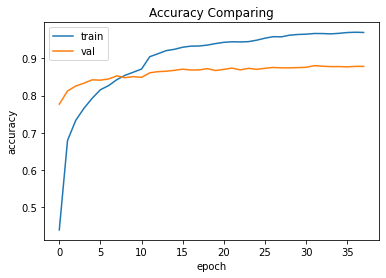

In [36]:
# Visualize accuracy
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
plt.title('Accuracy Comparing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

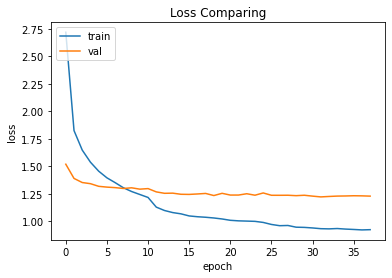

In [38]:
# Visualize loss
plt.plot(his['loss'])
plt.plot(his['val_loss'])
plt.title('Loss Comparing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

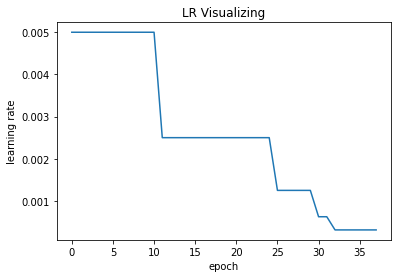

In [39]:
# Visualize learning rate
plt.plot(his['lr'])
plt.title('LR Visualizing')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()